In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from decord import VideoReader
import pickle

In [2]:
base_path = r"path_to_videos/\A{i}B{j}.mp4"
A_angles = [-45, 0, 45, 90]
B_angles = [-22.5, 22.5, 67.5, 112.5]

videos = {}

for i, alpha in enumerate(A_angles):
    for j, beta in enumerate(B_angles):
        path = base_path.format(i=i+1, j=j+1)
        videos[path] = (alpha, beta)

In [3]:
start_offset = 30
sample_frames_for_callibration = 30
min_frame_diff_for_merge = 15

# taken from tomography part, b is BR and t is TL
t_full_flux = 127401
b_full_flux = 126027

# decide if random noise or from laser
snr_threshold = 8000
# decide if 0 or 1 (on normlized values)
# final_threshold = 0.2


def split_frame_to_cameras(frame):
    top = frame[120:250,780:900, 0]
    bottom = frame[500:630,780:900, 0]
    return top, bottom

def get_baseline(video_path):
    vr = VideoReader(video_path)
    vr.seek(start_offset)
    cal_t, cal_b = [], []
    for i in range(sample_frames_for_callibration):
        f = vr.next().asnumpy()
        t, b = split_frame_to_cameras(f)
        cal_t.append(t)
        cal_b.append(b)
    del(vr)
    b_baseline = np.array(cal_b).mean(axis=0)
    t_baseline = np.array(cal_t).mean(axis=0)
    return t_baseline, b_baseline

    
def detect(arr):
    return arr[arr > np.percentile(arr, 80)].sum()

def get_intesity(video_path):
    t_baseline, b_baseline = get_baseline(video_path)

    vr = VideoReader(video_path)
    vr.seek(start_offset)
    I_t, I_b = [], []

    for i in range(len(vr)-start_offset):
        f = vr.next().asnumpy()
        t, b = split_frame_to_cameras(f)
        t, b = t.astype(float), b.astype(float)
        t -= t_baseline
        b -= b_baseline
        I_t.append(detect(t))
        I_b.append(detect(b))

    del(vr)
    return I_t, I_b

def ewma(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha

    scale = 1/alpha_rev
    n = data.shape[0]

    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0]*alpha_rev**(r+1)
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

def denoise_signal(sig):
    sig = np.array(sig)
    return sig - ewma(sig, 200)

def merge_close_detections(signal):
    detections = signal > snr_threshold
    candidate_frames = np.concatenate((np.where(detections)[0], [0])) # append [0] in the end to get the final detection as jump
    frame_diffs = np.abs(np.ediff1d(candidate_frames))
    jumps = np.argwhere(frame_diffs>min_frame_diff_for_merge).reshape(-1)
    signal_samples = []
    for i in range(jumps.shape[0]):
        start = jumps[i]
        end = jumps[i+1] if i+1 < len(jumps) else len(candidate_frames)
        frames = candidate_frames[start]
        signal_samples.append(np.mean(signal[frames]))
    
    clean_signal = np.zeros_like(signal)
    clean_signal[candidate_frames[jumps]] = signal_samples
    return clean_signal

def get_simul_signals(t_clean, b_clean, time_diff_threshold=20):
    t_clean_det = np.argwhere(t_clean > 0)
    b_clean_det = np.argwhere(b_clean > 0)

    diff_mat = np.subtract.outer(t_clean_det, b_clean_det).reshape((t_clean_det.shape[0], b_clean_det.shape[0]))

    t_diff_from_b = np.abs(diff_mat).min(axis=1) 
    b_diff_from_t = np.abs(diff_mat).min(axis=0)

    t_simul_det = t_clean_det[t_diff_from_b < time_diff_threshold].reshape(-1)
    b_simul_det = b_clean_det[b_diff_from_t < time_diff_threshold].reshape(-1)

    print(f"t detections: {t_simul_det.shape}, b detections: {b_simul_det.shape}")

    t_simul_sig, b_simul_sig = np.zeros_like(t_clean), np.zeros_like(b_clean)
    t_simul_sig[t_simul_det] = t_clean[t_simul_det]
    b_simul_sig[b_simul_det] = b_clean[b_simul_det]
    return t_simul_sig, b_simul_sig

# def calc_N_Ntot(t_simul, b_simul):
#     t_norm = t_simul / t_full_flux
#     b_norm = b_simul / b_full_flux

#     t_frac = t_norm[t_norm>final_threshold].mean()
#     b_frac = b_norm[b_norm>final_threshold].mean()
    
#     N_over_N_tot = t_frac * b_frac
#     return N_over_N_tot

In [4]:

def calc_PVV_PHH(t_norm, b_norm):
    true_seq = np.array([int(x) for x in "10010111011110000"]).astype(bool)
    true_seq = true_seq[:min(len(t_norm[t_norm>0]), len(b_norm[b_norm>0]))]
    H_idxs = np.argwhere(true_seq==1)
    V_idxs = np.argwhere(true_seq==0)    
        
    print(t_norm.shape, b_norm.shape)
    t_V = t_norm[t_norm>0][V_idxs]
    t_H = t_norm[t_norm>0][H_idxs]
    b_V = b_norm[b_norm>0][V_idxs]
    b_H = b_norm[b_norm>0][H_idxs]
    
    return t_V, t_H, b_V, b_H

In [5]:
T_intensities_H = {}
T_intensities_V = {}
B_intensities_H = {}
B_intensities_V = {}

final_signals = {}
for video_path, (alpha, beta) in tqdm(videos.items()):
    print((alpha, beta))
    print(video_path)
    t_I, b_I = get_intesity(video_path)

    t_denoised = denoise_signal(t_I)
    t_merged = merge_close_detections(t_denoised)

    b_denoised = denoise_signal(b_I)
    b_merged = merge_close_detections(b_denoised)
    
    t_sim_sig, b_sim_sig  = get_simul_signals(t_merged, b_merged)
    b_norm = b_sim_sig / b_full_flux
    t_norm = t_sim_sig / t_full_flux
    
    final_signals[(alpha, beta)] = t_sim_sig, b_sim_sig
    t_V, t_H, b_V, b_H = calc_PVV_PHH(t_norm, b_norm)
    
    T_intensities_V[(alpha, beta)] = t_V.mean()
    B_intensities_V[(alpha, beta)] = b_V.mean()
    
    T_intensities_H[(alpha, beta)] = t_H.mean()
    B_intensities_H[(alpha, beta)] = b_H.mean()
        

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

(-45, -22.5)
C:\Users\hacoh\physics\year3 semester a\quantum tomography\qm_bell_tomo_exp\bell_exp\A1B1.mp4


  6%|█████▏                                                                             | 1/16 [00:08<02:04,  8.27s/it]

t detections: (17,), b detections: (17,)
(3651,) (3651,)
(-45, 22.5)
C:\Users\hacoh\physics\year3 semester a\quantum tomography\qm_bell_tomo_exp\bell_exp\A1B2.mp4


 12%|██████████▍                                                                        | 2/16 [00:16<01:54,  8.15s/it]

t detections: (18,), b detections: (18,)
(3872,) (3872,)
(-45, 67.5)
C:\Users\hacoh\physics\year3 semester a\quantum tomography\qm_bell_tomo_exp\bell_exp\A1B3.mp4


 19%|███████████████▌                                                                   | 3/16 [00:24<01:47,  8.27s/it]

t detections: (17,), b detections: (17,)
(3959,) (3959,)
(-45, 112.5)
C:\Users\hacoh\physics\year3 semester a\quantum tomography\qm_bell_tomo_exp\bell_exp\A1B4.mp4


 25%|████████████████████▊                                                              | 4/16 [00:33<01:39,  8.30s/it]

t detections: (18,), b detections: (18,)
(3638,) (3638,)
(0, -22.5)
C:\Users\hacoh\physics\year3 semester a\quantum tomography\qm_bell_tomo_exp\bell_exp\A2B1.mp4


 31%|█████████████████████████▉                                                         | 5/16 [00:40<01:29,  8.15s/it]

t detections: (18,), b detections: (18,)
(3584,) (3584,)
(0, 22.5)
C:\Users\hacoh\physics\year3 semester a\quantum tomography\qm_bell_tomo_exp\bell_exp\A2B2.mp4


 38%|███████████████████████████████▏                                                   | 6/16 [00:49<01:21,  8.15s/it]

t detections: (17,), b detections: (17,)
(3629,) (3629,)
(0, 67.5)
C:\Users\hacoh\physics\year3 semester a\quantum tomography\qm_bell_tomo_exp\bell_exp\A2B3.mp4


 44%|████████████████████████████████████▎                                              | 7/16 [00:56<01:12,  8.01s/it]

t detections: (17,), b detections: (17,)
(3524,) (3524,)
(0, 112.5)
C:\Users\hacoh\physics\year3 semester a\quantum tomography\qm_bell_tomo_exp\bell_exp\A2B4.mp4


 50%|█████████████████████████████████████████▌                                         | 8/16 [01:06<01:07,  8.40s/it]

t detections: (17,), b detections: (17,)
(3621,) (3621,)
(45, -22.5)
C:\Users\hacoh\physics\year3 semester a\quantum tomography\qm_bell_tomo_exp\bell_exp\A3B1.mp4


 56%|██████████████████████████████████████████████▋                                    | 9/16 [01:16<01:04,  9.16s/it]

t detections: (17,), b detections: (17,)
(3480,) (3480,)
(45, 22.5)
C:\Users\hacoh\physics\year3 semester a\quantum tomography\qm_bell_tomo_exp\bell_exp\A3B2.mp4


 62%|███████████████████████████████████████████████████▎                              | 10/16 [01:29<01:01, 10.20s/it]

t detections: (18,), b detections: (18,)
(3178,) (3178,)
(45, 67.5)
C:\Users\hacoh\physics\year3 semester a\quantum tomography\qm_bell_tomo_exp\bell_exp\A3B3.mp4


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [01:39<00:50, 10.14s/it]

t detections: (17,), b detections: (17,)
(3084,) (3084,)
(45, 112.5)
C:\Users\hacoh\physics\year3 semester a\quantum tomography\qm_bell_tomo_exp\bell_exp\A3B4.mp4


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [01:49<00:40, 10.00s/it]

t detections: (17,), b detections: (17,)
(3179,) (3179,)
(90, -22.5)
C:\Users\hacoh\physics\year3 semester a\quantum tomography\qm_bell_tomo_exp\bell_exp\A4B1.mp4


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [01:58<00:29,  9.93s/it]

t detections: (17,), b detections: (17,)
(3086,) (3086,)
(90, 22.5)
C:\Users\hacoh\physics\year3 semester a\quantum tomography\qm_bell_tomo_exp\bell_exp\A4B2.mp4


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [02:06<00:18,  9.37s/it]

t detections: (16,), b detections: (16,)
(2961,) (2961,)
(90, 67.5)
C:\Users\hacoh\physics\year3 semester a\quantum tomography\qm_bell_tomo_exp\bell_exp\A4B3.mp4


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [02:15<00:09,  9.01s/it]

t detections: (17,), b detections: (17,)
(3237,) (3237,)
(90, 112.5)
C:\Users\hacoh\physics\year3 semester a\quantum tomography\qm_bell_tomo_exp\bell_exp\A4B4.mp4


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [02:23<00:00,  8.97s/it]

t detections: (17,), b detections: (17,)
(3266,) (3266,)


In [29]:
with open("./Ps.pkl", "wb") as f:
    pickle.dump(Ps, f)

with open("./final_signals.pkl", "wb") as f:
    pickle.dump(final_signals, f)

In [6]:
l_0 = []
l_45 = []
l_minus_45 = []
l_90 = []
for beta in B_angles:
    l_0.append(B_intensities_V[(0, beta)])
    l_45.append(B_intensities_V[(45, beta)])
    l_minus_45.append(B_intensities_V[(-45, beta)])
    l_90.append(B_intensities_V[(90, beta)])

Text(0, 0.5, 'relative intensity [dimensionless]')

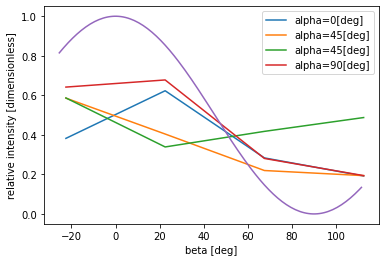

In [7]:
sns.lineplot(x=B_angles, y=l_0, label="alpha=0[deg]")
sns.lineplot(x=B_angles, y=l_45, label="alpha=45[deg]")
sns.lineplot(x=B_angles, y=l_minus_45, label="alpha=45[deg]")
sns.lineplot(x=B_angles, y=l_90, label="alpha=90[deg]")

xs = np.arange(-25.5, 112.5)
ys = np.square(np.cos(np.deg2rad(xs)))
plt.plot(xs, ys)

plt.xlabel("beta [deg]")
plt.ylabel("relative intensity [dimensionless]")

In [8]:
l_0 = []
l_45 = []
l_minus_45 = []
l_90 = []

for alpha in A_angles:
    l_0.append(T_intensities_V[(alpha, -22.5)])
    l_45.append(T_intensities_V[(alpha, 22.5)])
    l_minus_45.append(T_intensities_V[(alpha, 67.5)])
    l_90.append(T_intensities_V[(alpha, 112.5)])

Text(0, 0.5, 'relative intensity [dimensionless]')

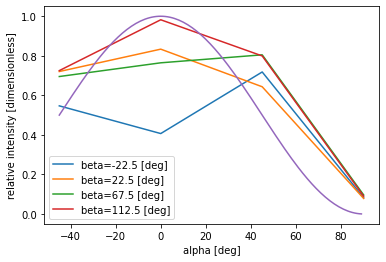

In [9]:
sns.lineplot(x=A_angles, y=l_0, label="beta=-22.5 [deg]")
sns.lineplot(x=A_angles, y=l_45, label="beta=22.5 [deg]")
sns.lineplot(x=A_angles, y=l_minus_45, label="beta=67.5 [deg]")
sns.lineplot(x=A_angles, y=l_90, label="beta=112.5 [deg]")

xs = np.arange(-45, 90)
ys = np.square(np.cos(np.deg2rad(xs)))
plt.plot(xs, ys)
plt.xlabel("alpha [deg]")
plt.ylabel("relative intensity [dimensionless]")

In [50]:
l_0 = []
l_45 = []
l_minus_45 = []
l_90 = []
for beta in B_angles:
#     _, b_sig = final_signals[(0, 22.5)]
    l_0.append(B_intensities_V[(0, beta)] * T_intensities_V[(0, beta)])
    l_45.append(B_intensities_V[(45, beta)] * T_intensities_V[(45, beta)])
    l_minus_45.append(B_intensities_V[(-45, beta)] * T_intensities_V[(-45, beta)])
    l_90.append(B_intensities_V[(90, beta)] * T_intensities_V[(90, beta)])


Text(0, 0.5, 'I_a * I_b [coincidence, dimensionless]')

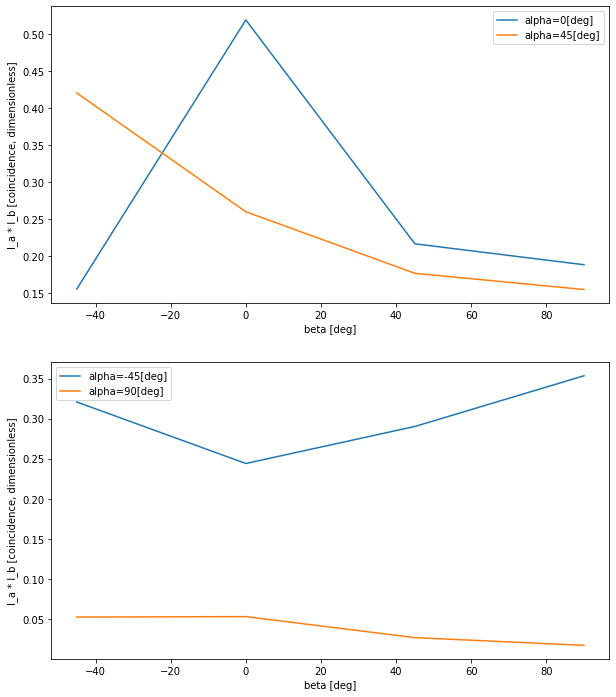

In [70]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 12))
sns.lineplot(x=A_angles, y=l_0, label="alpha=0[deg]", ax=ax1)
sns.lineplot(x=A_angles, y=l_45, label="alpha=45[deg]", ax=ax1)
sns.lineplot(x=A_angles, y=l_minus_45, label="alpha=-45[deg]", ax=ax2)
sns.lineplot(x=A_angles, y=l_90, label="alpha=90[deg]", ax=ax2)



# xs = np.arange(-45, 90)
# ys = np.square(np.cos(np.deg2rad(xs)))
# plt.plot(xs, ys)
ax1.set_xlabel("beta [deg]")
ax1.set_ylabel("I_a * I_b [coincidence, dimensionless]")
ax2.set_xlabel("beta [deg]")
ax2.set_ylabel("I_a * I_b [coincidence, dimensionless]")

<AxesSubplot:>

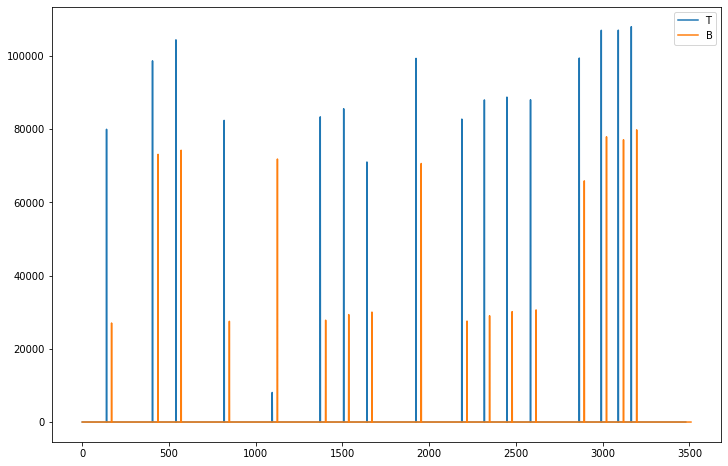

In [80]:
t, b = final_signals[(45, -22.5)]
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
sns.lineplot(t, label="T", ax=ax1)
sns.lineplot(np.concatenate(([0]*30, b)), label="B", ax=ax1)

In [16]:
df_TV = pd.DataFrame.from_records([{"alpha": alpha, "beta": beta, "Intensity": I} for (alpha, beta), I in T_intensities_V.items()])
df_TH = pd.DataFrame.from_records([{"alpha": alpha, "beta": beta, "Intensity": I} for (alpha, beta), I in T_intensities_H.items()])
df_BV = pd.DataFrame.from_records([{"alpha": alpha, "beta": beta, "Intensity": I} for (alpha, beta), I in B_intensities_V.items()])
df_BH = pd.DataFrame.from_records([{"alpha": alpha, "beta": beta, "Intensity": I} for (alpha, beta), I in B_intensities_H.items()])

In [43]:
df_1 = pd.merge(df_TV, df_BV, on=["alpha", "beta"]).rename(columns={"Intensity_x": "I_A", "Intensity_y": "I_B"})
df_2 = pd.merge(df_TH, df_BH, on=["alpha", "beta"]).rename(columns={"Intensity_x": "I_A", "Intensity_y": "I_B"})

In [22]:
df_2['alpha'] = df_2['alpha'].apply(lambda x: x+90 if x <=0 else x-90)
df_2['beta'] = df_2['beta'].apply(lambda x: x+90 if x <60 else x-90)

In [25]:
df = df_1.merge(df_2, on=['alpha', 'beta']) 
df['I_A'] = (df['I_A_x'] + df['I_A_y']) / 2
df['I_B'] = (df['I_B_x'] + df['I_B_y']) / 2

<AxesSubplot:xlabel='beta [deg]', ylabel='relative intensity [dimensionless]'>

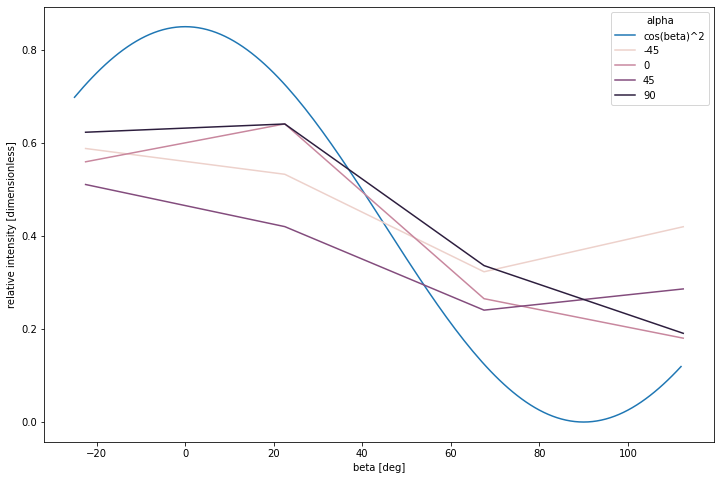

In [42]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

xs = np.arange(-25, 112.5)
ys = 0.85*np.square(np.cos(np.deg2rad(xs)))
plt.xlabel("beta [deg]")
plt.ylabel("relative intensity [dimensionless]")

sns.lineplot(x=xs, y=ys, label="cos(beta)^2")
sns.lineplot(data=df, x="beta", y="I_B", hue="alpha")

<AxesSubplot:xlabel='alpha [deg]', ylabel='relative intensity [dimensionless]'>

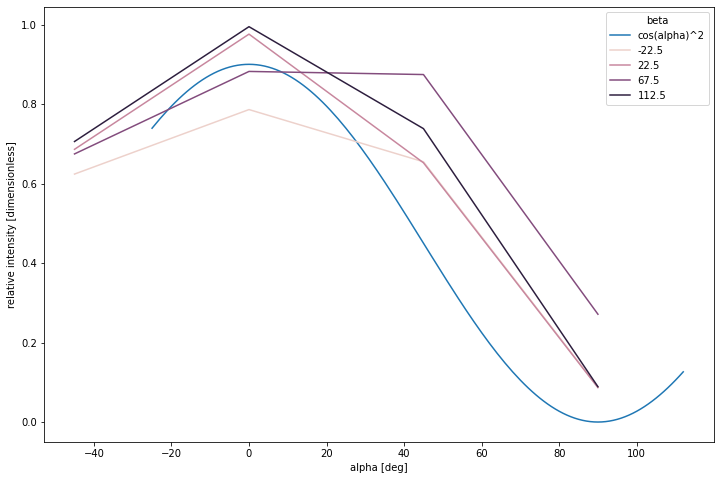

In [40]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

xs = np.arange(-25, 112.5)
ys = 0.9*np.square(np.cos(np.deg2rad(xs)))
plt.xlabel("alpha [deg]")
plt.ylabel("relative intensity [dimensionless]")

sns.lineplot(x=xs, y=ys, label="cos(alpha)^2")
sns.lineplot(data=df, x="alpha", y="I_A", hue="beta")

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

xs = np.arange(-25, 112.5)
ys = 0.9*np.square(np.cos(np.deg2rad(xs)))
plt.xlabel("alpha [deg]")
plt.ylabel("relative intensity [dimensionless]")

sns.lineplot(x=xs, y=ys, label="cos(alpha)^2")
sns.lineplot(data=df, x="alpha", y="I_A", hue="beta")

In [53]:
# df = df.drop(columns=["I_A_x","I_B_x","I_A_y","I_B_y"])
df['Coincidant detection (I_A * I_B)'] = df['I_A'] * df["I_B"]
df['I_A'] = df['I_A'].apply(lambda x: round(x, 2))
df["I_B"] = df["I_B"].apply(lambda x: round(x, 2)) 
df['Coincidant detection (I_A * I_B)'] = df['Coincidant detection (I_A * I_B)'].apply(lambda x: round(x, 2))

In [69]:
def calc_E(df, a, b):
    P_VV = df.loc[(df['alpha']==a)&(df['beta']==b), 'Coincidant detection (I_A * I_B)'].item()
    P_HH = df.loc[(df['alpha']==a+90)&(df['beta']==b+90), 'Coincidant detection (I_A * I_B)'].item()
    P_VH = df.loc[(df['alpha']==a+90)&(df['beta']==b), 'Coincidant detection (I_A * I_B)'].item()
    P_HV = df.loc[(df['alpha']==a)&(df['beta']==b+90), 'Coincidant detection (I_A * I_B)'].item()
    return P_VV + P_HH - P_VH - P_HV

In [71]:
a = -45
a_tag = 0
b = -22.5
b_tag = 22.5
S = calc_E(df, a, b) - calc_E(df, a, b_tag) + calc_E(df, a_tag, b) + calc_E(df, a_tag, b_tag)
S

0.6800000000000002

In [75]:
df

,alpha,beta,I_A,I_B,Coincidant detection (I_A * I_B)
0,-45,-22.5,0.62,0.59,0.37
1,-45,22.5,0.69,0.53,0.37
2,-45,67.5,0.67,0.32,0.22
3,-45,112.5,0.71,0.42,0.30
4,0,-22.5,0.79,0.56,0.44
5,0,22.5,0.98,0.64,0.63
6,0,67.5,0.88,0.27,0.23
7,0,112.5,0.99,0.18,0.18
8,45,-22.5,0.65,0.51,0.33
9,45,22.5,0.65,0.42,0.27
